In [4]:
import pytorch_lightning as pl
import torch
import yaml
from Models.ldm import AutoencoderKL
from Data.dataloaders import ABIDELoader
from functools import partial
import einops
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
with open(r"../Configurations/ABIDE/vae_config.yml", 'r+') as yaml_file:
    ae_config = yaml.safe_load(yaml_file)
model = AutoencoderKL(**ae_config)
model.load_state_dict(
    torch.load(r"/Users/balazsmorvay/Downloads/epoch=51-step=75500.ckpt", map_location='cpu')['state_dict'])
model.to(device='cpu')
model.eval()

making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(61, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(8, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(8, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNo

In [3]:
transforms = {
    'fmri': [
        partial(einops.rearrange, pattern='b h l d -> b 1 d h l')
    ]
}

batch_size = 1
datahandler = ABIDELoader(
    root_dir=r"/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc",
    exp_path=r"../Configurations/ABIDE/",
    batch_size=batch_size,
    transforms=transforms,
    rescale=True,
    num_workers=0,
    prefetch_factor=None,
    persistent_workers=None
)
trainer = pl.Trainer()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


  0%|          | 0/2957 [00:00<?, ?it/s]/Users/balazsmorvay/anaconda3/envs/VAE/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
  0%|          | 0/2957 [00:00<?, ?it/s]


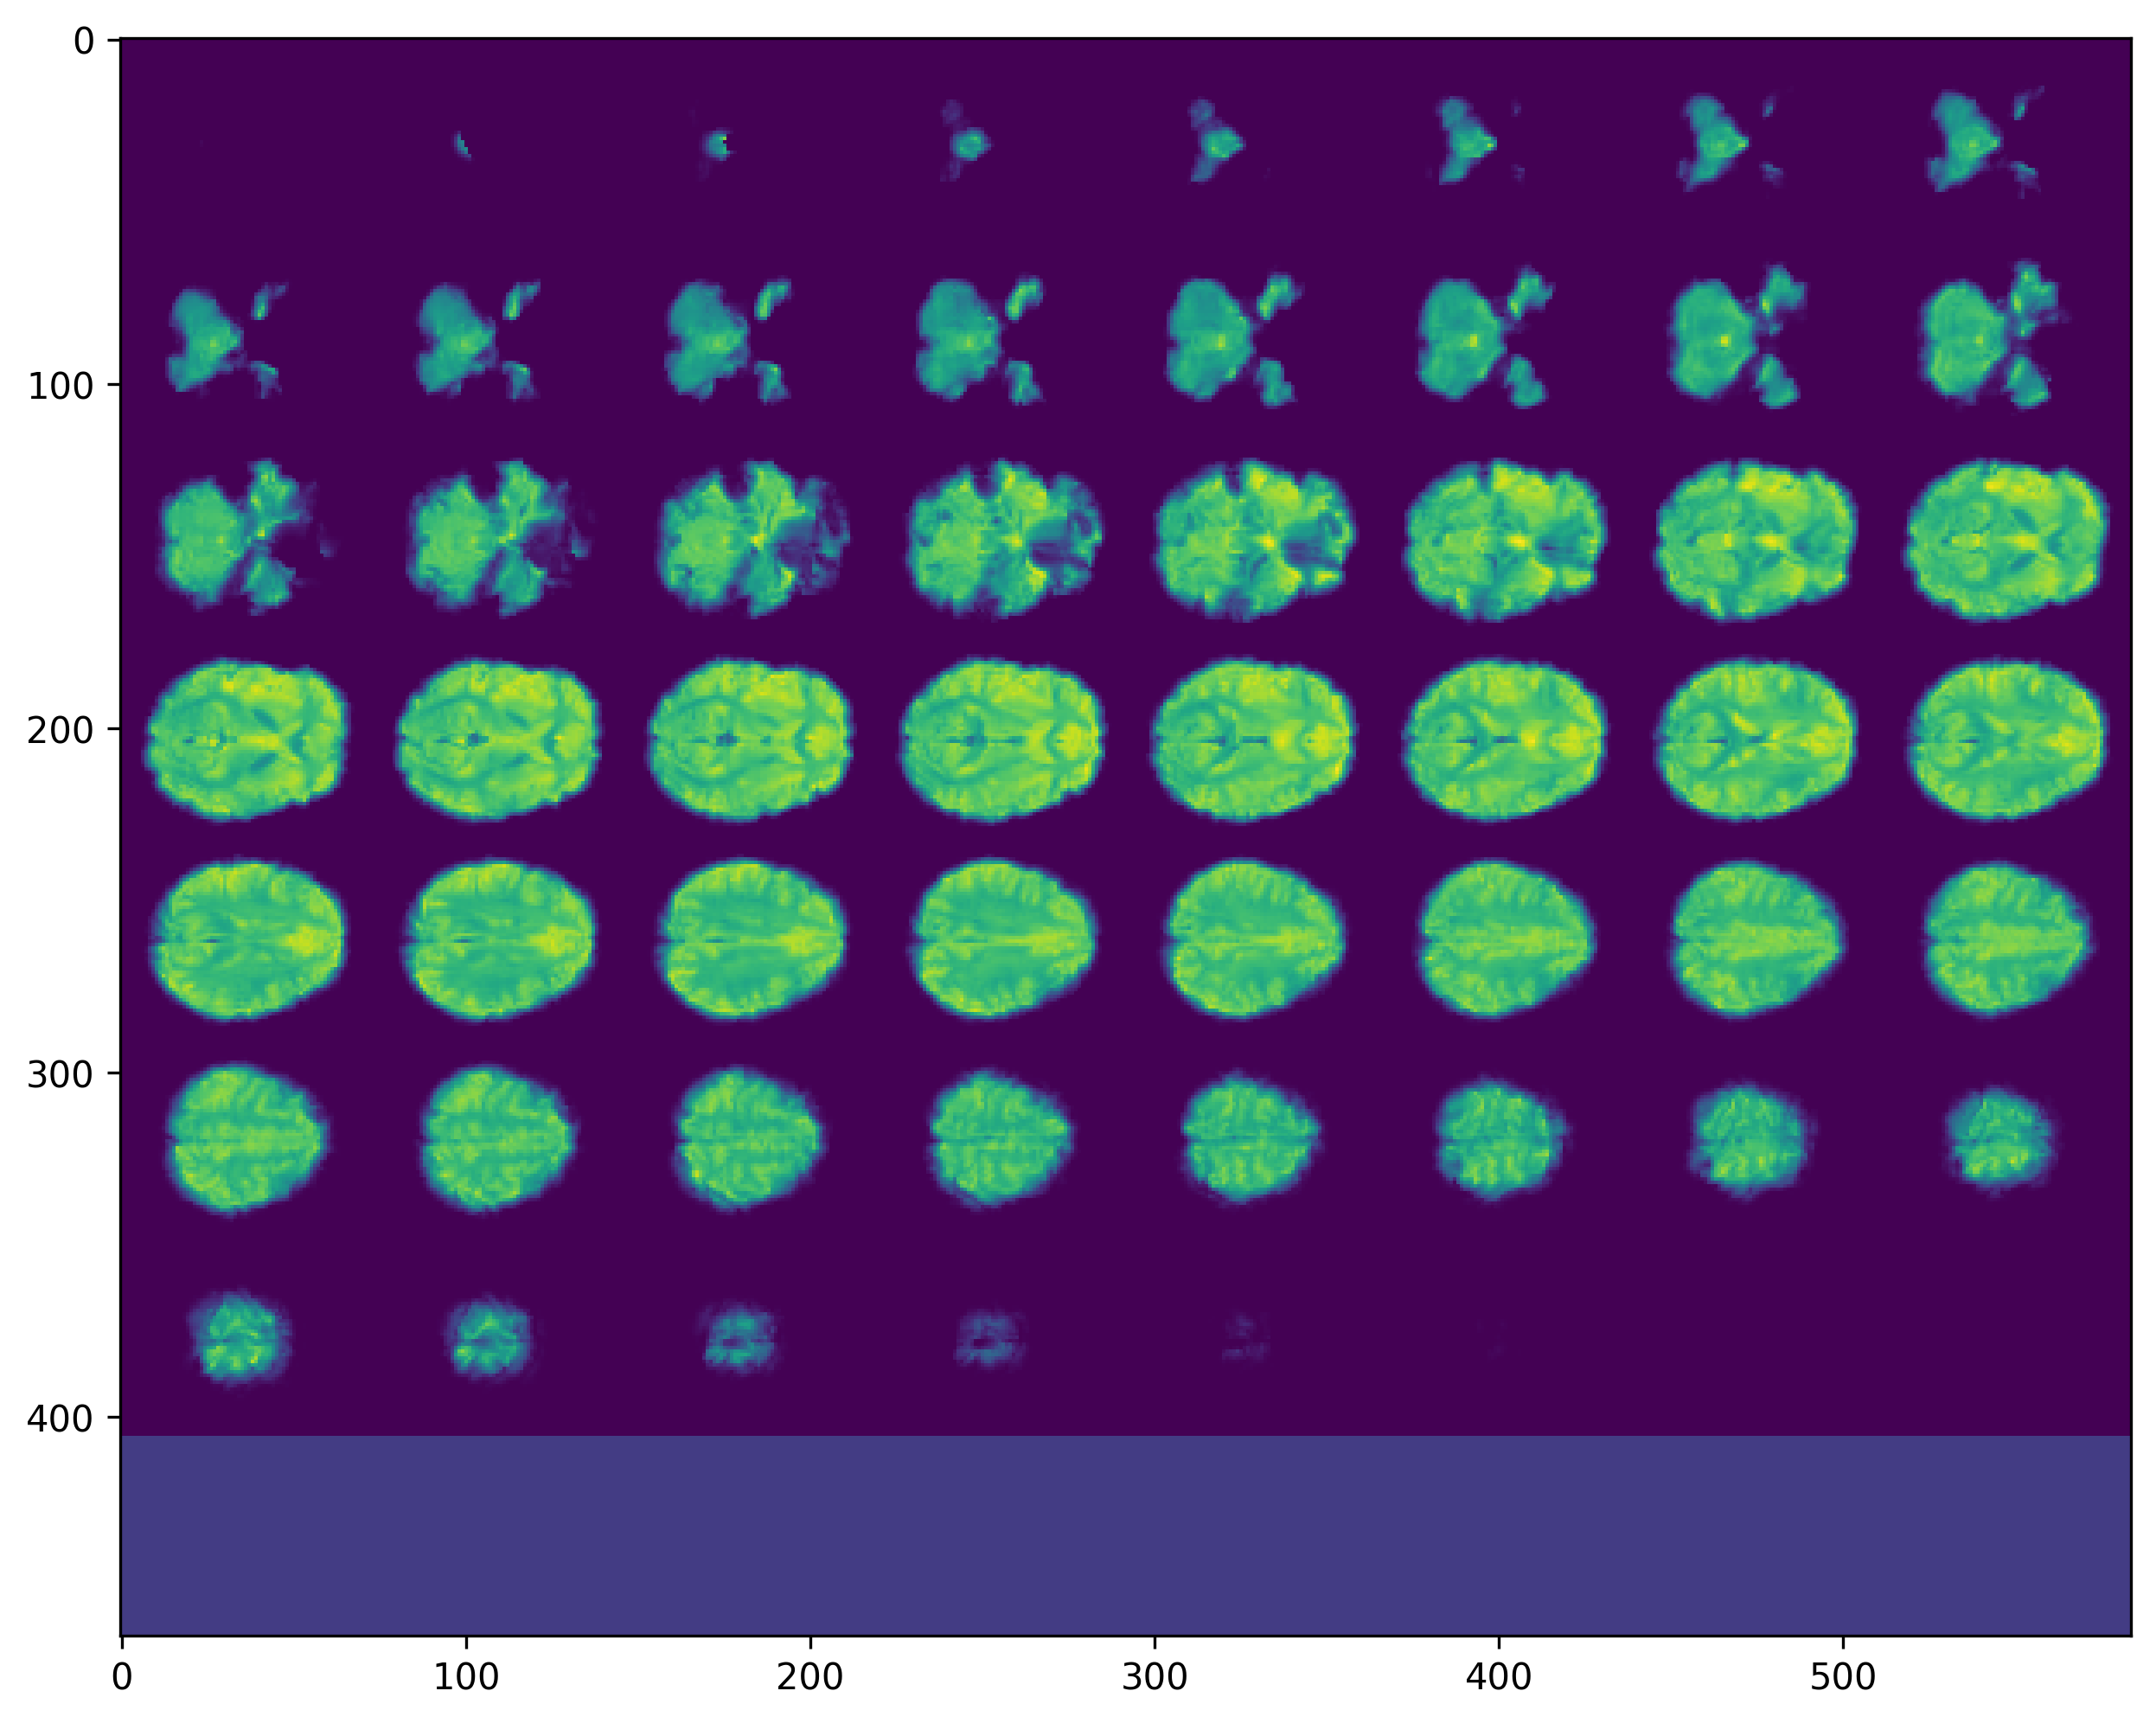

In [5]:
from skimage.util import montage

datahandler.setup('test')
dataloader = datahandler.test_dataloader()

with torch.inference_mode():
    for i in tqdm(range(len(dataloader))):
        inp = next(iter(dataloader))
        inp = datahandler.on_after_batch_transfer(inp, i)
        inp_fmri = model.get_input(inp, 'fmri')
        outp = model.encode(inp_fmri.squeeze(0)).mode().cpu()
        outp = (outp - outp.min()) / (outp.max() - outp.min()) * 2 - 1

        plt.figure(figsize=(3000/300, 3000/300), dpi=300)
        plt.imshow(montage(inp_fmri[0, 0, :56, :-3].cpu()))
        break